In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 모듈 설치

In [ ]:
# 모델링 모듈
!pip install tensorflow-addons
!pip install neuralprophet[live]
!pip install prophet

In [ ]:
# 폰트설치 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 모듈 및 라이브러리

In [715]:
# 내장 라이브러리
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

# 외장 라이브러리
from typing import collections, List, Tuple, Dict, DefaultDict, NewType
from collections import Counter
from datetime import datetime, timedelta
from timeit import default_timer as timer

# sklearn
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Facebook Prophet - 시계열 모델
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.plot import plot_yearly
# Neural Prophet - Advanced Facebook Prophet
from neuralprophet import NeuralProphet
# 시계열 모델
from statsmodels.tsa.arima_model import ARIMA
# Attention 모델
import keras
from tensorflow_addons.layers import MultiHeadAttention

In [39]:
# plot 한글
import platform
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False

if platform.system() == 'Darwin': # 맥os 사용자의 경우에
    plt.style.use('seaborn-darkgrid') 
    rc('font', family = 'AppleGothic')
    
elif platform.system() == 'Windows':# 윈도우 사용자의 경우에
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.style.use('seaborn-darkgrid') # https://python-graph-gallery.com/199-matplotlib-style-sheets/
    rc('font', family=font_name)

elif platform.system() == 'Linux': # colab 사용자의 경우에
  # 나눔고딕 폰트
  plt.rc('font', family='NanumBarunGothic') 


# 데이터 로드

In [572]:
## 중량 수온 데이터를 합친 dataframe, 품목 별로 불러오기
os.chdir('/content/drive/MyDrive/BIGCONTEST/data/real_use')

name = input('수산물 어종을 고르세요 (오징어/흰다리새우/연어)')

if name == "오징어":
  data = pd.read_csv("./squid_temp1.csv")
  val_df = pd.read_csv("./squid_temp2.csv")
elif name == "흰다리새우":
  data = pd.read_csv("./shrimp_temp1.csv")
  val_df = pd.read_csv("./shrimp_temp2.csv")
elif name == "연어":
  data = pd.read_csv("./salmon_temp1.csv")
  val_df = pd.read_csv("./salmon_temp2.csv")
else:
  None

수산물 어종을 고르세요 (오징어/흰다리새우/연어)오징어


In [573]:
# 품목별 dataframe을 생성하고, 일자별 거래의 갯수를 리스트 형태로 저장
def datasetting(data, p_name):

  just_p = pd.DataFrame(columns=data.columns.tolist())
  len_list = []
  for i, day_time in enumerate(list(Counter(data['REG_DATE']).keys())):
    day_df = data[data['REG_DATE']==day_time]
    just_p = pd.concat([just_p, day_df[day_df['P_NAME']==p_name]])
    len_list.append(len(day_df[day_df['P_NAME']==p_name]))

  return just_p, len_list

In [574]:
# import type을 multi-hot encoding 하기 위한 방법
def data_encoding(df, type_):
  tmp = []
  for impo in df[type_]:
    types = impo.split(',')
    for i in types:
      tmp.append(i)
  return list(set(tmp))

In [575]:
train, t_len = datasetting(data, name)
validation, v_len = datasetting(val_df, name)

In [576]:
## 제조국과 수출국에 대하여 multi-hot encoding을 진행하기위해서 모든 나라를 리스트형태로 저장
ctry_1 = set(list(set(train['CTRY_1']))+list(set(train['CTRY_2'])))
ctry_2 = set(list(set(validation['CTRY_1']))+list(set(validation['CTRY_2'])))
con = list(ctry_1) + list(ctry_2)
ctry_list = list(set(con))

In [577]:
## 명목형 변수는 dummy 처리해서 multi-hot 형태로 할당하고, 수치형 변수는 스케일링 작업 진행

def data_frame(trains, ctry_list):

  p_type = "P_IMPORT_TYPE"
  import_type = data_encoding(train, p_type)

  con = ctry_list
  con.sort()
  col_con = [f"country_{co}" for co in con]
  col_imp = [f"import_{im}" for im in import_type]
  cols = col_con + col_imp + ['weight', 'temp', 'price']
  # print(cols)
  x_train = pd.DataFrame(columns=cols)
  tmp = []
  for i in range(len(cols)-1):
    tmp.append([])
  len_a = len(col_con)
  len_b = len(col_imp)
  for c1, c2, p in zip(trains['CTRY_1'], trains['CTRY_2'], trains['P_IMPORT_TYPE']):
    i = con.index(c1)
    j = con.index(c2)
    country = np.eye(len_a)[i] + np.eye(len_a)[j] ## 제조국 + 수출국 정보 결합

    p_import = np.zeros(len_b)
    for ty in p.split(','):
      j = import_type.index(ty)
      p_import += np.eye(len(p_import))[j] ## import type 정보 결합

    row = np.concatenate([country, p_import])

    for i, r in enumerate(row):
      tmp[i].append(r)

  for i, c in enumerate(cols[:-3]): ## 중량, 수온, 가격 이외의 것들만 고려
    x_train[c] = tmp[i]

  ## 중량과 수온 데이터 스케일링
  w = trains['WEIGHT(KG)'].tolist()
  w = np.array(w).reshape(-1,1)
  t = trains['temp'].tolist()
  t = np.array(t).reshape(-1,1)

  scaler = MinMaxScaler()
  scaler.fit(w)
  t_data = scaler.transform(w)

  wscaler = MinMaxScaler()
  wscaler.fit(t)
  w_data = wscaler.transform(t)

  x_train['weight'] =  t_data
  x_train['temp'] = w_data
  x_train['price'] = trains['P_PRICE'].tolist()

  return x_train

In [578]:
x_train = data_frame(train, ctry_list)

In [579]:
x_val = data_frame(validation, ctry_list)

# 학습, 테스트 데이터 분리 

In [580]:
X_train = np.array(x_train.iloc[:,:-1])
Y_train = np.array(x_train.iloc[:,-1])
Y_train = Y_train.reshape(-1)

In [581]:
X_val = np.array(x_val.iloc[:,:-1])
Y_val = np.array(x_val.iloc[:,-1])
Y_val = Y_val.reshape(-1)

In [582]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((1333, 25), (1333,), (388, 25), (388,))

In [583]:
num_heads=8; head_size=32; ff_dim=None; dropout=0

multi = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)

In [584]:
## Attention을 계산하는 모듈 생성

class AttentionBlock(keras.Model):
    def __init__(self, name='AttentionBlock', num_heads=2, head_size=128, ff_dim=None, dropout=0.2, **kwargs):
        super().__init__(name=name, **kwargs)

        if ff_dim is None:
            ff_dim = head_size

        self.attention = MultiHeadAttention(num_heads=num_heads, head_size=head_size, dropout=dropout)
        self.attention_dropout = keras.layers.Dropout(dropout)
        self.attention_norm = keras.layers.LayerNormalization(epsilon=1e-6)

        self.ff_conv1 = keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')
        self.flatten = keras.layers.Flatten()
        self.dense1 = keras.layers.Dense(64, activation='relu')
        self.dense2 = keras.layers.Dense(1)
        self.ff_dropout = keras.layers.Dropout(dropout)
        self.ff_norm = keras.layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        self.ff_conv2 = keras.layers.Conv1D(filters=input_shape[-1], kernel_size=1) 

    def call(self, inputs):
        x = self.attention([inputs, inputs])
        x = self.attention_dropout(x)
        x = self.attention_norm(inputs + x)
        
        return x

In [585]:
## Attention을 여러번 계산하고 마치막 출력으로 Fully_connected layer를 통해 차원 축소

class ModelTrunk(keras.Model):
    def __init__(self, name='ModelTrunk', num_heads=2, head_size=128, ff_dim=None, num_layers=10, dropout=0, **kwargs):
      super().__init__(name=name, **kwargs)
      if ff_dim is None:
          ff_dim = head_size
      self.dropout = dropout
      self.attention_layers = [AttentionBlock(num_heads=num_heads, head_size=head_size, ff_dim=ff_dim, dropout=dropout) for _ in range(num_layers)]
      self.dense2 = keras.layers.Dense(1, kernel_initializer='he_normal')

    def call(self, inputs):
      x = inputs
      for attention_layer in self.attention_layers:
          x = attention_layer(x)
      x = self.dense2(x)
      return x

In [586]:
# Attention 계산 및 FC layer 차원축소 
attention_layers = ModelTrunk()

In [587]:
# 소프트맥스 함수 
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [588]:
# Attention - FC layer 를 통한 가중치 리스트와 가격 리스트 생성
def make_weight(x, y,length):
    # 날짜별로 attention score 담을 list
    weight_score = []
    # 날짜별로 p_price 담을 list
    p_price = []
    final_weight = []

    before = 0
    for leng in length:
      if leng==0:
        weight_score.append([[0]])
        p_price.append([[0]])
      else:
        a = np.array(x[before:before+leng])
        b = np.array(y[before:before+leng]).tolist()
        arr = attention_layers(a)
        weight_score.append(np.array(softmax(arr)).tolist()) ## attention score를 softmax 함수를 이용해서 정규화
        p_price.append(b)
        before += leng

    for w in weight_score:
        aa = sum(w, [])
        final_weight.append(aa)

    return final_weight,p_price

In [589]:
train_weight, train_price = make_weight(X_train, Y_train, t_len)

In [590]:
val_weight, val_price = make_weight(X_val, Y_val,v_len)

In [591]:
# 가중치를 이용한 새로운 가격 변수 생성
def make_new_price(weight_list, price_list):
    new_price = []
    new_price_m = 0
    new_price_s = 0

    for i in range(len(weight_list)):
        if weight_list[i]==[0]:
            new_price.append(0)
        else:
            for j in range(len(weight_list[i])):
                new_price_m += (weight_list[i][j] * price_list[i][j])
                new_price_s += weight_list[i][j]
            new_price_sum = new_price_m / new_price_s
            new_price.append(new_price_sum)
    return new_price

In [592]:
# attention score의 가중치를 적용한 가중평균 
train_price = make_new_price(train_weight, train_price)

In [593]:
val_price = make_new_price(val_weight, val_price)

In [594]:
trn_lst = np.array([item for item in train_price if item > 0])

In [595]:
train['REG_DATE'] = pd.to_datetime(train['REG_DATE'])
validation['REG_DATE'] = pd.to_datetime(validation['REG_DATE'])

In [599]:
# 가중평균한 최종 가격 배열로 만들기 
ts_train = np.array(train_price)

# RMSE 함수 (평가지표)

In [604]:
def rmse(y: List, yhat:List)->float:
  # y값의 갯수
  n = len(y)
  mse = 0
  for i in range(n):
    # 실제값에서 예측값 뺀것의 제곱
    mse += (y[i] - yhat[i])**2
  rmse = (mse/n)**0.5
  return rmse

- validation y : val_price


# Neural Prophet - normal

In [605]:
## 모델 피팅하기 위해서 dataframe 형태 수정
df = pd.DataFrame(columns=['ds', 'y'])
df['ds'] = train['REG_DATE'].unique()
df['y'] = ts_train
print(df.shape)

(195, 2)


In [606]:
# hyperparameter 
freq = 'W-MON' # 시작일이 월요일이면서, 일주일 간격 
epochs = 1000

In [607]:
# 모델 학습
m = NeuralProphet()
metrics = m.fit(df, freq =freq,
                epochs=epochs)

INFO: nprophet.utils - set_auto_seasonalities: Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:40<00:00, 24.98it/s, SmoothL1Loss=0.00216, MAE=0.0508, RegLoss=0]


In [608]:
# 예측 기간 데이터셋 생성
val_date = list(validation['REG_DATE'].unique())
future = pd.DataFrame(val_date, columns=['ds'])
future['y'] = None

In [609]:
# train 데이터의 마지막일 기준으로, 일주일 간격 * 70 의 테스트데이터 생성
future = m.make_future_dataframe(df, periods=70)
forecast = m.predict(future)

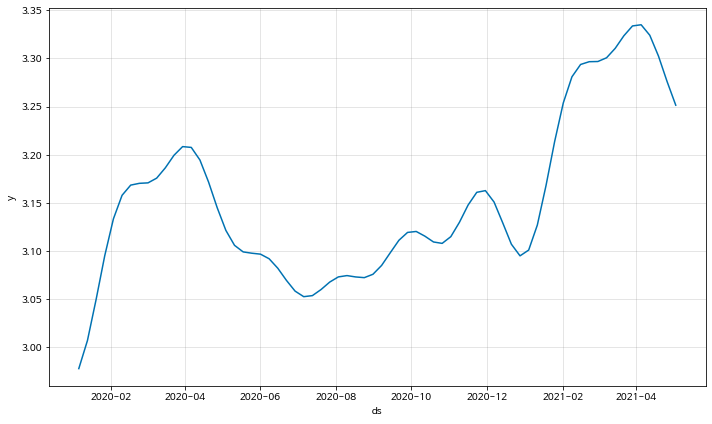

In [610]:
forecasts_plot = m.plot(forecast)

In [611]:
# validation 기간에 맞는 예측 데이터 프레임 구성
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in val_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [612]:
# rmse
rmse(val_price, a['yhat1'])

0.21945749430163583

# Neural Prophet - Trend

In [614]:
m = NeuralProphet(
    n_changepoints=100,
    #trend_smoothness=2,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    epochs =epochs
)
metrics = m.fit(df, freq=freq)

INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.23E+00
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:35<00:00, 28.07it/s, SmoothL1Loss=0.000633, MAE=0.0168, RegLoss=0]


In [615]:
future = m.make_future_dataframe(df, periods=70, n_historic_predictions=len(df))
forecast = m.predict(future)

In [616]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in val_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [617]:
# rmse
rmse(val_price, a['yhat1'])

0.14983437083772141

# Nueral Prophet - Seasonality

In [668]:
m = NeuralProphet(
    n_changepoints=200,
    yearly_seasonality=15,
    weekly_seasonality=3,
    seasonality_reg=30,
    num_hidden_layers=20,
)
metrics = m.fit(df, freq=freq)

INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 164


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E+00
Epoch[164/164]: 100%|██████████| 164/164 [00:05<00:00, 27.35it/s, SmoothL1Loss=0.00168, MAE=0.0319, RegLoss=0]


In [669]:
future = m.make_future_dataframe(df, periods=70, n_historic_predictions=len(df))
forecast = m.predict(future)

In [670]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in val_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [671]:
# rmse
rmse(val_price, a['yhat1'])

0.1538531509472624

# 최적 하이퍼 파라미터


In [682]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = 0.005


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = 20 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 200 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

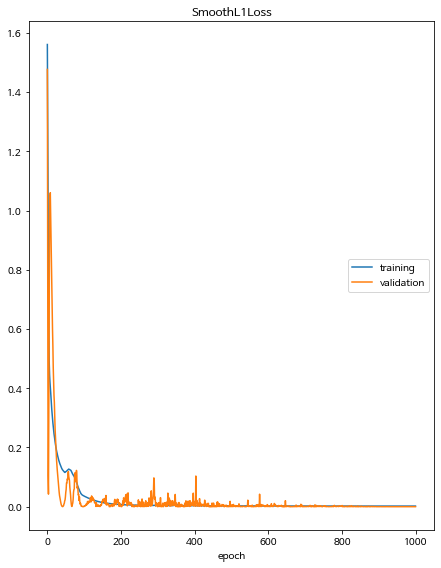

Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:51<00:00, 19.29it/s, SmoothL1Loss=0.00207, MAE=0.0416, RegLoss=0.00156, MAE_val=0.00966, SmoothL1Loss_val=3.58e-5]


In [683]:
nprophet = NeuralProphet(
            yearly_seasonality=False, 
            weekly_seasonality=True, 
            daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, 
            n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, 
            n_changepoints=n_changepoints, 
            growth='logistic', 
            seasonality_mode='multiplicative', 
            trend_reg=trend_reg,
            num_hidden_layers=num_hidden_layers,
            seasonality_reg = seasonality_reg
        )

nprophet.fit(df, plot_live_loss=True, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)

In [684]:
future = nprophet.make_future_dataframe(df, periods=52, n_historic_predictions=300)
forecast = nprophet.predict(future)
forecast[['ds', 'y', 'yhat1', 'trend']].tail(5)
forecast.tail()

,ds,y,yhat1,residual1,trend,season_weekly,season_daily
242,2020-11-30,NaN,2.916267,NaN,2.916268,-4.756471e-08,-1.187782e-07
243,2020-12-07,NaN,2.915223,NaN,2.915224,-4.756471e-08,-1.187782e-07
244,2020-12-14,NaN,2.914179,NaN,2.914179,-4.756471e-08,-1.187782e-07
245,2020-12-21,NaN,2.913135,NaN,2.913135,-4.756471e-08,-1.187782e-07
246,2020-12-28,NaN,2.912091,NaN,2.912091,-4.756471e-08,-1.187782e-07


In [685]:
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
for i in val_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)

In [686]:
rmse(val_price, a['yhat1'])

0.12872867160440898

# 최적 하이퍼 파라미터 ver.2

In [693]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = 0.01


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = 20 # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = 200 # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

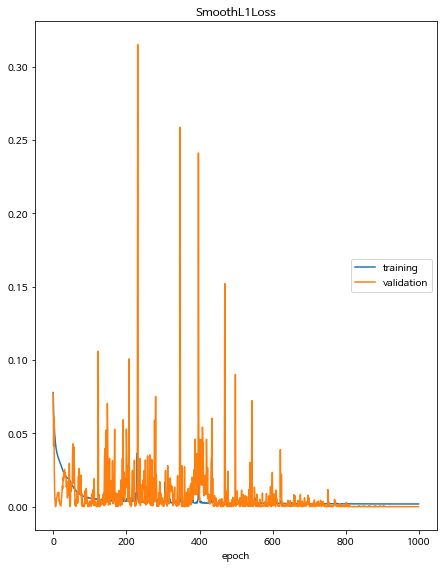

Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:51<00:00, 19.47it/s, SmoothL1Loss=0.00186, MAE=0.0344, RegLoss=0.00151, MAE_val=0.00883, SmoothL1Loss_val=2.86e-5]


In [694]:
nprophet = NeuralProphet(
            yearly_seasonality=False, 
            weekly_seasonality=True, 
            daily_seasonality=True,
            learning_rate=learning_rate, 
            changepoints_range=changepoints_range, 
            n_forecasts=n_forecasts,
            ar_sparsity=ar_sparsity, 
            n_changepoints=n_changepoints, 
            growth='logistic', 
            seasonality_mode='multiplicative', 
            trend_reg=trend_reg,
            num_hidden_layers=num_hidden_layers,
            seasonality_reg = seasonality_reg
        )

nprophet.fit(df, plot_live_loss=True, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)

In [695]:
future = nprophet.make_future_dataframe(df, periods=52, n_historic_predictions=300)
forecast = nprophet.predict(future)
forecast[['ds', 'y', 'yhat1', 'trend']].tail(5)

,ds,y,yhat1,trend
242,2020-11-30,NaN,2.874910,2.874911
243,2020-12-07,NaN,2.873126,2.873126
244,2020-12-14,NaN,2.871342,2.871342
245,2020-12-21,NaN,2.869558,2.869558
246,2020-12-28,NaN,2.867774,2.867774


In [696]:
# validation 날짜와 맞는 데이터 추출하기 위한 데이터 프레임
a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])

for i in val_date:
  a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
a.reset_index(drop=True, inplace = True)
rmse(val_price, a['yhat1'])

0.12246338637921825

# 최적 하이퍼 파라미터 ver.3

In [717]:
## neural prophet
epochs = 1000
# batch_size = 64
learning_rate = [0.005, 0.01, 0.015]


# AR net 
n_forecasts = 52 # 예측 기간의 크기  # future_periods랑 같아야한다. 
num_hidden_layers = [10,20,30] # AR-net compelxity 조절 
ar_sparsity = 0.8  # 0-1, 0에 가까울수록 sparse함 

# d_hidden = 64 
# trend_smoothness = 0.5
n_changepoints = [100, 150, 200] # 변화점(changepoint)의 갯수 설정 
changepoints_range = 1.0 # 변화점을 전체 데이터셋에서 몇 퍼센트 감지할지
trend_reg = 0.03
seasonality_reg=30

#n_lags = 5  # >error : lambda delay가 없다

In [723]:
# 파라미터별 rmse 저장할 데이터 프레임 생성 
result = pd.DataFrame(columns=['learning_rate','num_hidden_layers','n_changepoints','rmse'])
# 데이터 프레임 row index 변수 생성
count=0
# 파라미터 조합 반복문 실행
for lr in learning_rate:
  for layer in num_hidden_layers:
    start = timer()
    for changepoint in n_changepoints:

      nprophet = NeuralProphet(
                                yearly_seasonality=False, 
                                weekly_seasonality=True, 
                                daily_seasonality=True,
                                learning_rate=lr, 
                                changepoints_range=changepoints_range, 
                                n_forecasts=n_forecasts,
                                ar_sparsity=ar_sparsity, 
                                n_changepoints=changepoint, 
                                growth='logistic', 
                                seasonality_mode='multiplicative', 
                                trend_reg=trend_reg,
                                num_hidden_layers=layer,
                                seasonality_reg = seasonality_reg)
      
      nprophet.fit(df, plot_live_loss=False, epochs=epochs, freq=freq, validate_each_epoch=True, valid_p=0.1)
      #nprophet.highlight_nth_step_ahead_of_each_forecast(step_number=nprophet.n_forecasts)
      future = nprophet.make_future_dataframe(df, periods=52, n_historic_predictions=300)
      forecast = nprophet.predict(future)
      a = pd.DataFrame(columns=['ds', 'y', 'yhat1', 'residual1', 'trend', 'season_yearly'])
      for i in val_date:
        a = a.append(forecast.iloc[forecast.loc[forecast['ds']==i].index])
      a.reset_index(drop=True, inplace = True)
      result.loc[count] = lr, layer, changepoint, rmse(val_price, a['yhat1'])
      count += 1
      end = timer()
      print(end-start)

ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:46<00:00, 21.62it/s, SmoothL1Loss=0.00223, MAE=0.0437, RegLoss=0.00132, MAE_val=0.0414, SmoothL1Loss_val=0.000725]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


46.49236288099928


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 21.15it/s, SmoothL1Loss=0.00203, MAE=0.0391, RegLoss=0.00135, MAE_val=0.0278, SmoothL1Loss_val=0.000293]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


93.99934310900062


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:48<00:00, 20.76it/s, SmoothL1Loss=0.00209, MAE=0.04, RegLoss=0.00152, MAE_val=0.00984, SmoothL1Loss_val=5.63e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


142.377741641998


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:46<00:00, 21.33it/s, SmoothL1Loss=0.00819, MAE=0.0795, RegLoss=0.31, MAE_val=0.0849, SmoothL1Loss_val=0.00262]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


47.112336415000755


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 21.12it/s, SmoothL1Loss=0.00199, MAE=0.0398, RegLoss=0.00148, MAE_val=0.00725, SmoothL1Loss_val=2.56e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


94.68228524699953


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 21.26it/s, SmoothL1Loss=0.00207, MAE=0.0385, RegLoss=0.0015, MAE_val=0.0269, SmoothL1Loss_val=0.000334]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


141.93205381900043


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 20.99it/s, SmoothL1Loss=0.00226, MAE=0.044, RegLoss=0.00129, MAE_val=0.0364, SmoothL1Loss_val=0.000587]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


47.87762120900152


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 20.99it/s, SmoothL1Loss=0.00199, MAE=0.0386, RegLoss=0.00139, MAE_val=0.00904, SmoothL1Loss_val=4.82e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


95.75239858200075


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 21.19it/s, SmoothL1Loss=0.00758, MAE=0.076, RegLoss=0.31, MAE_val=0.0539, SmoothL1Loss_val=0.00108]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


143.16965463000088


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 20.88it/s, SmoothL1Loss=0.00206, MAE=0.0369, RegLoss=0.00119, MAE_val=0.0154, SmoothL1Loss_val=0.00012]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


48.108060066999315


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 21.09it/s, SmoothL1Loss=0.00733, MAE=0.0759, RegLoss=0.31, MAE_val=0.0636, SmoothL1Loss_val=0.00149]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


95.74814110199804


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 21.00it/s, SmoothL1Loss=0.00735, MAE=0.0755, RegLoss=0.31, MAE_val=0.0576, SmoothL1Loss_val=0.00122]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


143.5828924289999


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 21.18it/s, SmoothL1Loss=0.00198, MAE=0.0362, RegLoss=0.00122, MAE_val=0.0194, SmoothL1Loss_val=0.00018]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


47.44711206200009


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 21.17it/s, SmoothL1Loss=0.00727, MAE=0.0763, RegLoss=0.31, MAE_val=0.0642, SmoothL1Loss_val=0.00151]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


94.89108615699661


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 21.13it/s, SmoothL1Loss=0.00734, MAE=0.0756, RegLoss=0.31, MAE_val=0.0614, SmoothL1Loss_val=0.00139]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


142.43456125899684


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 21.22it/s, SmoothL1Loss=0.00196, MAE=0.0361, RegLoss=0.00123, MAE_val=0.0155, SmoothL1Loss_val=0.000122]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


47.35853544699785


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 21.02it/s, SmoothL1Loss=0.00192, MAE=0.035, RegLoss=0.00137, MAE_val=0.0198, SmoothL1Loss_val=0.000186]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


95.16769340799874


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 20.96it/s, SmoothL1Loss=0.00185, MAE=0.0341, RegLoss=0.00143, MAE_val=0.01, SmoothL1Loss_val=5.36e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


143.11140835399783


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 21.07it/s, SmoothL1Loss=0.00201, MAE=0.0357, RegLoss=0.00116, MAE_val=0.0197, SmoothL1Loss_val=0.000183]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


47.689290584003174


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 20.92it/s, SmoothL1Loss=0.00198, MAE=0.0347, RegLoss=0.00122, MAE_val=0.0107, SmoothL1Loss_val=6.21e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


95.72520346200326


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:48<00:00, 20.76it/s, SmoothL1Loss=0.00194, MAE=0.0345, RegLoss=0.0013, MAE_val=0.0108, SmoothL1Loss_val=6.07e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


144.1299491130012


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 21.05it/s, SmoothL1Loss=0.00199, MAE=0.0355, RegLoss=0.00118, MAE_val=0.0178, SmoothL1Loss_val=0.00015]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


47.73828986599983


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 20.88it/s, SmoothL1Loss=0.00194, MAE=0.0343, RegLoss=0.00127, MAE_val=0.0134, SmoothL1Loss_val=8.9e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


95.84942463300104


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 21.00it/s, SmoothL1Loss=0.00192, MAE=0.034, RegLoss=0.00132, MAE_val=0.0132, SmoothL1Loss_val=8.87e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


143.69413221799914


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 21.00it/s, SmoothL1Loss=0.00198, MAE=0.0351, RegLoss=0.0012, MAE_val=0.0142, SmoothL1Loss_val=9.86e-5]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


47.8384127979989


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 21.05it/s, SmoothL1Loss=0.00742, MAE=0.0759, RegLoss=0.31, MAE_val=0.0653, SmoothL1Loss_val=0.00157]
ERROR: nprophet.config - __post_init__: Invalid trend growth 'logistic'. Set to 'linear'
INFO: nprophet.config - __post_init__: Note: Trend changepoint regularization is experimental.
INFO: nprophet.config - __post_init__: Note: Fourier-based seasonality regularization is experimental.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8


95.57499012599874


Epoch[1000/1000]: 100%|██████████| 1000/1000 [00:47<00:00, 20.87it/s, SmoothL1Loss=0.00735, MAE=0.0759, RegLoss=0.31, MAE_val=0.0681, SmoothL1Loss_val=0.0017]


143.7174429049992


In [726]:
result.sort_values(by='rmse', ascending=True)

,learning_rate,num_hidden_layers,n_changepoints,rmse
1,0.005,10.0,150.0,0.140541
17,0.010,30.0,200.0,0.148338
4,0.005,20.0,150.0,0.148824
20,0.015,10.0,200.0,0.149788
19,0.015,10.0,150.0,0.151639
7,0.005,30.0,150.0,0.153409
2,0.005,10.0,200.0,0.156755
22,0.015,20.0,150.0,0.156841
23,0.015,20.0,200.0,0.157972
24,0.015,30.0,100.0,0.158983
